# Tutorial n°2 - SDK : Reachy the mime

In this tutorial, we will learn how to do a more complex task with Reachy using the SDK client, with both arms and the mobile base, all moving together at the same time !

Here, we are going to transform Reachy into a mime who pulls an invisible rope. 

What you will learn : 

- How to use the mobile base,
- How to synchronize arms and mobile base movements,
- How and when to use blocking gotos,
- How to follow a trajectory with the end effector.



## 1. Prerequisites

To use the SDK client, you first need to install *reachy2-sdk*. If it is not the case, checkout the section below 👇
<details>

<summary>Install the Python library reachy2-sdk</summary>

In general, you'd better **work in a virtual environment**. You have 2 different ways to install the sdk : 
- by running the following command:

<code>
pip install reachy2-sdk
</code>

- from source by following the instructions on the [GitHub repository](https://github.com/pollen-robotics/reachy2-sdk)

</details>

If you have never used the SDK client before, don't forget to do the [Getting Started notebooks](https://github.com/pollen-robotics/reachy2-sdk/tree/develop/src/examples), that will help you understand all the basics you need to know about it ! And if you want to go further, you can also check the [SDK documentation](https://pollen-robotics.github.io/reachy2-docs/). 

## 2. Setup

### 2.1. Material

For this tutorial, you'll only need Reachy, and that's it ! 

Generally speaking, before making the real robot move, working on a **virtual Reachy is strongly recommended** to visualize the movements and try to modify them. Once you're sure that all your moves are safe for the robot, you can work on the real Reachy. 
Just know that for this tutorial, you won't be able to test it entirerely on the fake robot, as the mobile base is not set on virtual Reachy. 

### 2.2. Scene

Put Reachy in a safe environment with enough place to move around, no one in reachable space and no obstacles (as there are no safety yet preventing the robot from colliding with its environment). And always keep the emergency stop button nearby! 



## 3. Preview

In this tutorial, we'll build step by step the program that will enable Reachy to pull a rope. Here, you can have a look at what Reachy will do at the end :

<center> 
    <img src="./images//gif_rope.gif" alt="Gif 1" style="width: 30%; display: inline-block;"/>
</center>

Now that you are all set, let's dig into it ! 


## 4. Let's build it ! 

### 4.1. Instanciation of the SDK

First, we will connect to the robot. To do so, we need to import the SDK client package and to instanciate a ReachySDK.

Two requirements :
- Your computer needs to be on the same network as the robot.
- You need to know your Reachy's IP : to do so, you have two options : 
    - you can check it on the dashboard (*.local_IP_address_of_your_robot:8000* in a browser), section Network. 
    - you can have a look at the small screen on Reachy's back, that will show you one at a time its Ethernet and its Wifi IP. 

> 💡 You'll see that it's really easy to mistakenly run on the real robot before testing in simulation. So you can add a security on your code : if you put the IP of a real robot, the program will ask you a confirmation by pressing "y" or "yes" before executing anything. 

Now, let's connect to it.

In [19]:
#import the package
from reachy2_sdk import ReachySDK

IP = "10.0.0.253" # Change the IP to your Reachy's when you are ready to run the code for real

#add the security check
fake = IP == "localhost"

if not fake:
    res = input("Are you sure you want to execute on the real robot ? (y/N)")
    if res.lower() not in ["y", "yes"]:
        print("Aborted.")
        exit()

#connect to the robot        
reachy = ReachySDK(IP)

💡 Having the message "There is no available camera" is normal if you are working on a virtual Reachy.

If you are getting the message "Could not connect to Reachy", make sure that :
-  Reachy is turned on
- the reachy2_core.service is running 
- the IP address is correct. 

*More info on the debug section of the [sdk documentation](https://pollen-robotics.github.io/reachy2-docs/help/help/recovering/).<br>*

### 4.2. Set Reachy ready

### 4.2.1. Turn it on

Reachy has its motors off by default. So first, we need to turn them on. 

In [20]:
reachy.turn_on()
print(f"Reachy's motors are on : {reachy.is_on()}")

Reachy's motors are on : True


Then, we are going to place the robot in a neutral position, with the head looking straight ahead and the arms alongside its torso. You can use the *goto_posture* method to do so. 

In [21]:
reachy.goto_posture('default')

GoToHomeId(head=id: 500
, r_arm=id: 501
, l_arm=id: 502
)

### 4.2.2. The mobile base

Now, let's talk a little about how the mobile base works. 

To make it move, we have two ways : 
- *goto(x, y, theta)* method :
    > We set the **absolute** target position of the mobile base. Well, it's absolute, relative to the position it was when Reachy was started, or relative to the last position where `reset_odometry()` was called. For example, let's say we just powered the robot. The position of the mobile base is currently `x = 0, y = 0, theta = 0`, `(0, 0, 0)`. Now if we call `reachy.mobile_base.goto(0.2, 0, 0)`, after the robot has moved, its position is `(0.2, 0, 0)`. If we call `reachy.mobile_base.goto(0.2, 0, 0)` again, nothing will happen because Reachy is already at this position. 
    > Now if we call `reachy.mobile_base.reset_odometry()`, it will reset the mobile base's position, meaning its position is now `(0, 0, 0)` again, without moving the mobile base. Its new origin is the current position.
    > To be safe, we always call `reset_odometry()` before running our code here, because we may not know how the mobile base moved before. 

- *translate_by(x,y)* and *rotate_by(theta)* methods : 
    > You are safe, the reference position is always Reachy's current position.


Now that Reachy is on, we are going to reset the odometry to be sure (only if you are on the real robot and not the fake one) : 

In [22]:
if not fake :
    reachy.mobile_base.reset_odometry()

#### 4.2.3. Set the initial position

Now, let's set Reachy in an initial position where its elbows are at 90°. Conveniently, there is a feature in the SDK to do just that !

In [23]:
reachy.goto_posture('elbow_90')

GoToHomeId(head=id: 503
, r_arm=id: 504
, l_arm=id: 505
)

We save the current poses of the end effectors in *right_start_pose* and *left_start_pose* (as 4x4 homogeneous matrices), because we will build the next moves relative to these starting poses. 

In [24]:
# Save current effector poses 
right_start_pose = reachy.r_arm.forward_kinematics()
left_start_pose = reachy.l_arm.forward_kinematics()

print(f"Right arm start pose:\n {right_start_pose} \nLeft arm start pose:\n {left_start_pose}")

Right arm start pose:
 [[-2.25607478e-02  9.37733968e-04 -9.99745034e-01  3.86217593e-01]
 [ 8.41780815e-02  9.96450259e-01 -9.64961241e-04 -2.23203199e-01]
 [ 9.96195294e-01 -8.41783892e-02 -2.25595996e-02 -2.70357960e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
Left arm start pose:
 [[-2.25767664e-02 -9.35901082e-04 -9.99744674e-01  3.86216722e-01]
 [-8.41867726e-02  9.96449522e-01  9.68334155e-04  2.23202686e-01]
 [ 9.96194196e-01  8.41871394e-02 -2.25753986e-02 -2.70354489e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


For reference, these are the frames we'll be working with : 

<center>
<img src="./images/frame_reachy_default_pose.png" alt="Capture d’écran" width="300"/>
<img src="./images/frame_reachy_elbow90_pose.png" alt="Capture d’écran" width="300"/>
</center>

We consider the origin of the world to be Reachy's torso. So when we say we translate or rotate in "absolute", it means relative to Reachy's torso frame. 

> 💡 One important thing to notice is the gripper frames. You can see that they are oriented the same way as the torso when the arms are in the **default** position, meaning along the body. Now look at what happens when we set the arms at 90° : forward is `-z`, right is `-y` and up is `+x`. This can be a little counter intuitive when computing poses in the gripper's reference frame, so keep that in mind!

Reachy is now ready to start, let's move on to the next step !


### 4.3. Build the sequence

The mime sequence is composed of several parts to be synchronized together : 
- extension of one arm and gripper closing
- flexion of the other arm
- translation of the mobile base

The easiest way to build it (and it is a general rule when implementing complex behavior on the robot) is to break it down into smaller parts and implement them one by one independently. Once each part is working, you can combine them to create the full sequence.

Let's start with the first part ! 


#### 4.3.1. Extension of the arm

Let's compute the extended position for the right end effector. We start from the reference pose and : 
- adjust the position forwards and towards the middle
- rotate the effector to be perpendicular to the ground and in the robot's *x* axis

In [25]:
from reachy2_sdk.utils.utils import rotate_in_self

right_extend = right_start_pose.copy()
# Translate by 0.1m in the absolute x direction and by 0.2m in the absolute y direction
right_extend[:3, 3] += [0.1, 0.2, 0.0] 
# Rotate the end effector by 60° around y and -90° around z in the gripper's frame
right_extend = rotate_in_self(right_extend, [0, 60, -90]) 


Now we have our goal pose, let's Reachy make the move to reach it and when the move is done, close the gripper :

In [26]:
reachy.r_arm.goto(right_extend, duration=1.5, wait=True)
reachy.r_arm.gripper.close()

This is what you should see :

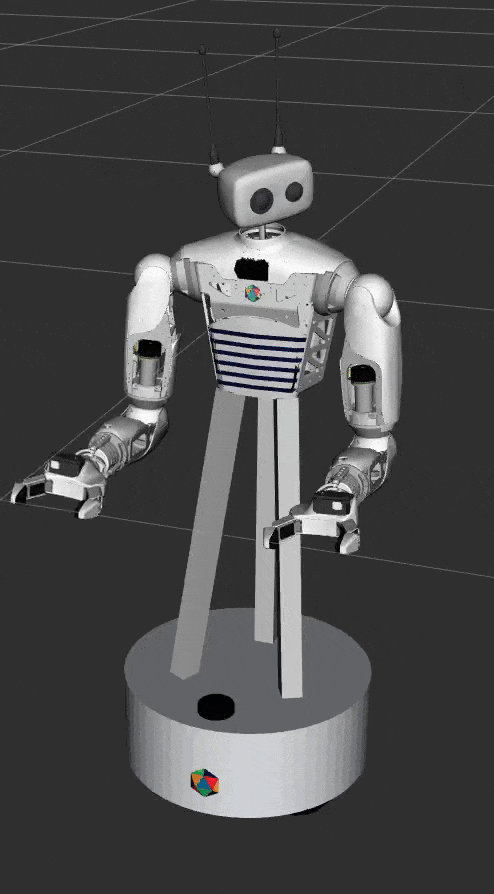



💡 Here, notice that the wait parameter is set to True in our call to *goto*(). 

> By default, the goto functions are not blocking, as the default value of *wait* is False, that means they're **not blocking calls** and they will execute asynchronously. They are executed in a separate thread, so they won't block the main thread, meaning the next instruction will be executed at the same time. 

Here, and typically in python, the function you call is **blocking**, meaning we have to wait for it to finish executing before executing the next instruction. That allows us to be sure that the gripper will close only when the arm has finished its movement. Without the addition of the *wait=True* parameter, the gripper would have closed during arm movement. You can change the parameter to see for yourself! 

Let's move on to the next part. 

#### 4.3.2. Flexion of the arm

Now, we want the right arm to translate along the `x` direction (by 0.2 meters), like if it had grasped a rope and pulled on it. 

We can use the translate_by() method for that. Go ahead and make the arm move : 

In [27]:
reachy.r_arm.translate_by(-0.2, 0, 0, duration=1.5, wait=False)

id: 507

Great ! Now, we need to make the mobile base move too. 

#### 4.3.3. Translation of the mobile base

We want the mobile base to move forward by the same amount the right arm has moved to create the illusion that Reachy pulled itself. We can use the goto function to do that. Make the mobile base move now (*only on the real robot*): 

In [28]:
if not fake : 
    reachy.mobile_base.goto(0.2,0,0)

#### 4.3.4. Make it work together

Now, we need to put all this moves work together at the same time. We want : 
- one arm to go in position to catch the rope
- the other arm to go backwards to pull the rope
- the mobile base to go forward

First, let's go back to the beginning by moving the mobile base to its origin and by making Reachy get the elbow_90 posture : 

In [29]:
if not fake : 
    reachy.mobile_base.goto(x=0, y=0, theta=0)
reachy.goto_posture('elbow_90')
reachy.r_arm.gripper.open()

Then, we make Reachy's right arm catch the rope as before : 

In [30]:
reachy.r_arm.goto(right_extend, duration=1.5, wait=True)
reachy.r_arm.gripper.close()

We build the left extend pose the same way as with the right arm, except that the translation on the y axis needs to be negative this time, to be close to the middle. 

In [31]:
left_extend = left_start_pose.copy()
left_extend[:3, 3] += [0.1, -0.2, 0.0]
left_extend = rotate_in_self(left_extend, [0, 60, 90])

Then we make all the other moves work together : 

> For now, we need to run the translation of the mobile base in a thread to be able to execute command on other Reachy's part in the same time, as the mobile base gotos are blocking, but that will change soon (so stay tuned!). 

In [32]:
import _thread
import time

## launch simultaneously all the moves 
#make the left arm go catch the rope
goto_id = reachy.l_arm.goto(left_extend, duration=2.0, wait=False) # Non-blocking

#make the right arm pull the rope
reachy.r_arm.translate_by(-0.2, 0, 0, duration=1.5, wait=False) # Non-blocking

#move the mobile base forward
if not fake: 
    _thread.start_new_thread(reachy.mobile_base.goto, (0.2, 0, 0))


## Wait for the end of the left arm move to close the gripper
if goto_id.id != 0:
    while not reachy.is_goto_finished(goto_id):
        time.sleep(0.1)
reachy.l_arm.gripper.close()

time.sleep(2)


Let's take a moment to understand what's going on here.

`reachy.arm.goto()` returns a `goto id`. This `goto id` allows us to ask the SDK if this move is finished using `reachy.is_goto_finished(goto_id)`. 

Here, we want to move both arms at the same time. But their durations are not the same (2.0s and 1.5s). We run all the moves in non blocking mode (left arm, right arm and mobile base), but then we want to wait for the first move to end before continuing. To do that, we can block the execution until `reachy.is_goto_finished(goto_id)` is True. 

That's what we do here with the `while not reachy.is_goto_finished(goto_id):` instruction.

The full move now looks like this : 

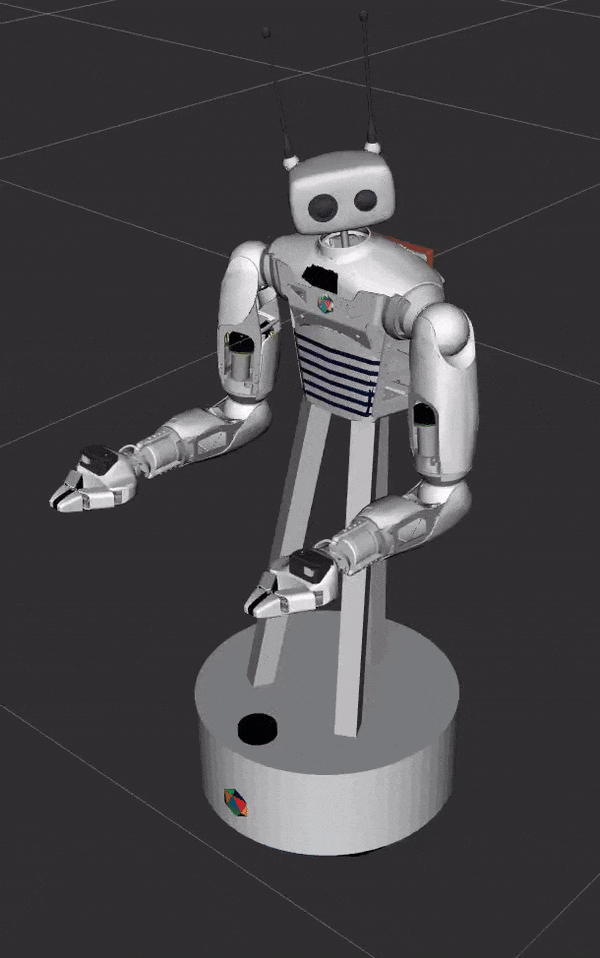

#### 4.3.5. Follow a trajectory

Now, we want :
- the left arm to translate along `x`the same way the right arm just did
- the right arm to go back into position to be ready to pull again
- the mobile base to move forward again

Here is where things get interesting. If we use `arm.translate_by()` or `arm.goto()`, we have no guarantee that the arms won't collide together performing their respective moves (spoiler alert : they will). 

So we want the right arm to go back the extended position by following a trajectory that will avoid the left arm.

To do that, we can use the feature that interpolates trajectory tracking: `send_cartesian_interpolation()` 
By default, it's a linear interpolation, but if you set the parameter 'arc_direction', you can follow a semi-circular trajectory until the target position. 
With the *arc_direction* parameter set to "right", the semi circle trajectory will be in the `(x, y)` plane, going to the right.

> 💡 Note that this function is **blocking**. 

In [33]:
#open the gripper
reachy.r_arm.gripper.open()

#move the mobile base forward
if not fake:
    reachy.mobile_base.reset_odometry()
    _thread.start_new_thread(reachy.mobile_base.goto, (0.2, 0, 0))

#move the left arm to pull the rope
reachy.l_arm.translate_by(-0.2, 0, 0, duration=1.5, wait=False)

#move the right arm to catch the rope with a semi-circular trajectory
reachy.r_arm.send_cartesian_interpolation(
    right_extend, duration=1.3, arc_direction="right", precision_distance_xyz=0.1
)

#close the gripper
reachy.r_arm.gripper.close()

Look at the trajectory of the right arm !

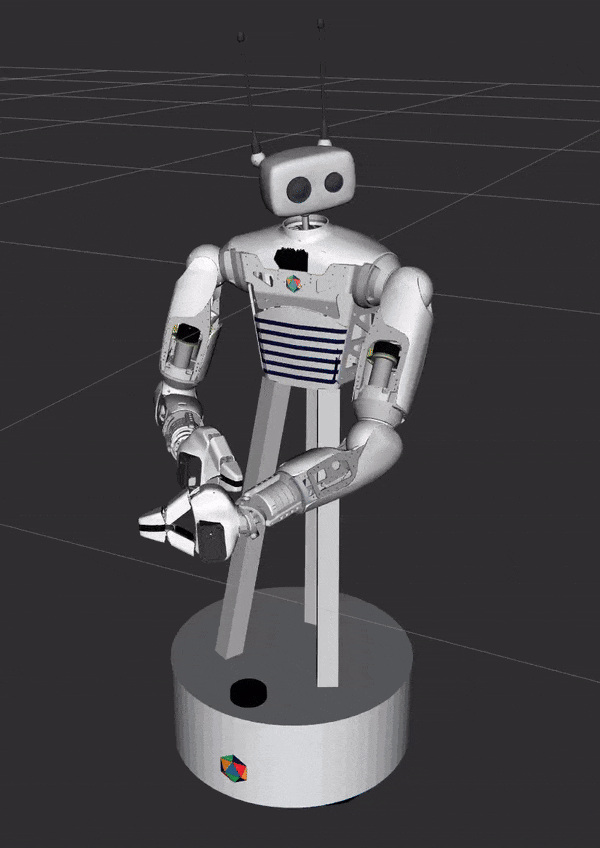

Now we just have to do the same with the left arm !
So at the same time, we : 
- open the left gripper
- move forward the mobile base
- pull the invisible rope with the right arm 
- move forward the left arm, using a semi-circular trajectory to the left this time

Then we close the left gripper. 

You can do it on your robot : 

In [34]:
#open the left gripper
reachy.l_arm.gripper.open()

#move the mobile base forward
if not fake:
    reachy.mobile_base.reset_odometry()
    _thread.start_new_thread(reachy.mobile_base.goto, (0.2, 0, 0))

#move the right arm to pull the rope
reachy.r_arm.translate_by(-0.2, 0, 0, duration=1.5, wait=False)

#move the left arm to catch the rope with a semi-circular trajectory
reachy.l_arm.send_cartesian_interpolation(
    left_extend, duration=1.3, arc_direction="left", precision_distance_xyz=0.1
)

#close the left gripper
reachy.l_arm.gripper.close()

Well done ! You did it ! Now that you understood how to do it, you can continue to move Reachy forward, or make a U-turn via the mobile base (*reachy.mobile_base.rotate_by(180)*), or do the same sequence but in reverse! 

Don't hesitate to try out and practice all Reachy's features ! 

Once you've finished, you can return Reachy to its initial position and log off. 

In [35]:
reachy.goto_posture('elbow_90', duration = 3, wait = True)
reachy.turn_off_smoothly()
reachy.disconnect()

1 : 0.03386807441711426
2 : 3.052271604537964
3 : 3.0575947761535645


## 5. Final tips

Now, you've learned how to build a sequence on Reachy using only the SDK Client with: 
- arms movements
- mobile base movements
- trajectory following
- synchronization between Reachy's parts

You can now use this sequence as a starting point to create other complex behaviors on the robot. Feel free to modify the movements, the duration of the movements, the order of the movements, etc. to get more familiar with the SDK, the robot and to check whether you can make Reachy do what you want it to do ! 

Here are some general tips to keep in mind to be the best at implementing complex behaviors on Reachy:

- **Always test behavior** on a fake robot before running it on the real robot! This will help you check if the behavior is doing what you expect it to do and to avoid any potential damage to the robot.
- If you are working on the real robot, make sure that it has enough space around it to move its arms and head, and **always** have the emergency shutdown nearby. Especially, make sure that the arms will not be blocked by objects such as a table as there are no safety yet preventing the robot for colliding with its environment.
- Split the behavior you wish to develop into smaller parts and implement them one by one. Once each part is working, you can combine them to create the full sequence. Go slow and test each part before moving on to the next one. 


## 6. Skip to the next tutorial ! 

Here, we've covered just a few of the methods that can be used on Reachy. To discover more ways of controlling the robot, don't hesitate to continue following the tutorials ! 

1. Reachy's awakening (with SDK only)

**2. Reachy the mime (with SDK only)**

3. Reachy the greengrocer (with SDK & Pollen-Vision)


Keep up and you'll be soon an expert to control Reachy ! 